<h1>COVID19 World and Italy monitor<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Notebook-Description" data-toc-modified-id="Notebook-Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Notebook Description</a></span></li><li><span><a href="#Italy-Monitor" data-toc-modified-id="Italy-Monitor-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Italy Monitor</a></span><ul class="toc-item"><li><span><a href="#provinces-analysis" data-toc-modified-id="provinces-analysis-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>provinces analysis</a></span></li><li><span><a href="#regional-analysis" data-toc-modified-id="regional-analysis-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>regional analysis</a></span></li><li><span><a href="#Model-fitting" data-toc-modified-id="Model-fitting-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Model fitting</a></span></li></ul></li><li><span><a href="#World-Monitor" data-toc-modified-id="World-Monitor-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>World Monitor</a></span><ul class="toc-item"><li><span><a href="#Country-comparisons" data-toc-modified-id="Country-comparisons-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Country comparisons</a></span></li><li><span><a href="#Model-fitting" data-toc-modified-id="Model-fitting-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Model fitting</a></span></li><li><span><a href="#SIR-epidemic-model" data-toc-modified-id="SIR-epidemic-model-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>SIR epidemic model</a></span></li></ul></li></ul></div>

# Notebook Description

<img src="image.png">

This repo contains analysis built around data about global and italian diffusion of COVID-19 that might be useful in monitoring the spread of coronavirus around the world.
This monitor does not by any means intend to provide any attempt to predict future evolutions of the virus but only to offer a visual tool to capture its dynamics.
Data are automatically downloaded from publicly available repos such as:

1) John Hopkins CSSE (https://github.com/CSSEGISandData/COVID-19) for world data

2) Protezione Civile Italiana (https://github.com/pcm-dpc/COVID-19) for national data

Just scroll down the notebook to perform various analysis on both worldwide and italian data

Code available at my repo:
https://github.com/mspadaccino/COVID-19

(jupyter notebook by Maurizio Spadaccino, april 2020)

In [48]:
%load_ext autoreload
%autoreload 2
import sys
import os
import types
sys.path.append('../')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from src import tools
from src.tools import func_log, func_gomp, func_exp, func_ext_log
from src.models import calibrate_SIR
import inspect
import plotly.express as px
from sklearn.linear_model import LinearRegression
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
from src.data_downloader import DATA_REPOS, download_from_repo
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import plotly.graph_objects as go
pd.set_option('display.max_columns', None)
from scipy.optimize import differential_evolution

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
dest=os.path.expanduser(os.path.join('~','Documents', 'projects', 'COVID-19', 'data'))

In [15]:
print('updating datasets from repos...')

updating datasets from repos...


In [16]:
print('downloading world data')
download_from_repo(DATA_REPOS['world']['url'], filenames=DATA_REPOS['world']['streams'], dest=dest)

downloading world data
last commit  2020-04-05 01:55:38


In [17]:
print('downloading Italian data')
download_from_repo(DATA_REPOS['italy']['url'], filenames=DATA_REPOS['italy']['streams'], dest=dest)

downloading Italian data
last commit  2020-04-05 18:20:27


In [23]:
df_naz = pd.read_csv('../data/dpc-covid19-ita-andamento-nazionale.csv').drop('stato',1)
reg = pd.read_csv('../data/dpc-covid19-ita-regioni.csv')
prov = pd.read_csv('../data/dpc-covid19-ita-province.csv').drop('stato',1)
df_naz.index = pd.to_datetime(df_naz.index)
reg['data'] = pd.to_datetime(reg['data'])
prov['data'] = pd.to_datetime(prov['data'])
df_world_confirmed = pd.read_csv('../data/time_series_covid19_confirmed_global.csv')
df_world_deaths = pd.read_csv('../data/time_series_covid19_deaths_global.csv')
df_world_recovered = pd.read_csv('../data/time_series_covid19_recovered_global.csv')
populations = pd.read_csv('../data/API_SP.POP.TOTL_DS2_en_csv_v2.csv', skiprows=4, engine='python').set_index('Country Name')['2018']
ita_populations = pd.read_csv('../data/popitaregions.csv')
df_world_confirmed['pop'] = df_world_confirmed['Country/Region'].map(populations)
df_world_deaths['pop'] = df_world_deaths['Country/Region'].map(populations)
df_world_recovered['pop'] = df_world_recovered['Country/Region'].map(populations)
df_naz = tools.add_extra_features(df_naz)
regions = reg.groupby('denominazione_regione')
df_reg = {}
df_reg['Italy'] = df_naz
for item in regions.groups:
    df_reg[item] = tools.add_extra_features(regions.get_group(item)).replace((np.inf, np.nan), 0)

provinces = prov.groupby('sigla_provincia')
df_prov = pd.DataFrame()
for item in provinces.groups:
    df_prov = pd.concat((df_prov,tools.add_extra_features(provinces.get_group(item)).replace((np.inf, np.nan), 0)),0)

In [24]:
pop_replace = [('US', 'United States'), ('Korea, South', 'Korea, Rep.'), 
               ('Venezuela','Venezuela, RB'), ('Bahamas','Bahamas, The'), 
               ('Iran','Iran, Islamic Rep.'), ('Russia','Russian Federation'), 
               ('Egypt','Egypt, Arab Rep.'), ('Syria','Syrian Arab Republic'),
               ('Slovakia','Slovak Republic'),('Czechia','Czech Republic'),
               ('Congo (Brazzaville)','Congo, Rep.'),
               ('Congo (Kinshasa)','Congo, Dem. Rep.'),('Kyrgyzstan','Kyrgyz Republic'),
               ('Laos','Lao PDR'),('Brunei','Brunei Darussalam'),
               ('Gambia', 'Gambia, The')]
for item in pop_replace:
    try:
        populations.loc[item[0]] = populations.loc[item[1]]
        del populations[item[1]]
    except Exception as e:
        print(e)
        
pops = ita_populations.loc[ita_populations['Regione']=='Trentino-Alto Adige', ['Popolazione','Superficie sqkm','ab/sqkm','Numero_comuni','Numero_province']].values/2
newdf = pd.DataFrame(index = ['P.A. Trento', 'P.A. Bolzano', 'Italy'], columns=ita_populations.set_index('Regione').columns)
newdf.loc['P.A. Trento']=pops[0]
newdf.loc['P.A. Bolzano']=pops[0]
newdf.loc['Italy']= [populations.loc['Italy'], 0., 0., 0., 0.]
newdf.reset_index(inplace=True)
newdf.rename(columns={'index': 'Regione'}, inplace=True)
ita_populations = pd.concat((ita_populations,newdf)).set_index('Regione')

In [25]:
data_columns = ['ricoverati_con_sintomi','terapia_intensiva','totale_ospedalizzati','isolamento_domiciliare','totale_positivi',
           'variazione_totale_positivi','nuovi_positivi','dimessi_guariti','deceduti','totale_casi','tamponi',
           'delta_totale_casi','%delta_totale_casi','growth_factor','delta_dimessi_guariti','%delta_dimessi_guariti',
           'delta_deceduti','%delta_deceduti','deceduti_su_tot','deceduti_su_dimessi']
prov_data_columns = ['totale_casi', 'delta_totale_casi', '%delta_totale_casi', 'growth_factor']
model_columns = ['ricoverati_con_sintomi', 'terapia_intensiva', 'totale_ospedalizzati', 'isolamento_domiciliare', 
                 'totale_positivi','nuovi_positivi', 'dimessi_guariti', 'deceduti', 'delta_deceduti', 'totale_casi', 
                 'tamponi', 'deceduti_su_tot', 'deceduti_su_dimessi']
models = {'gompertz': func_gomp, 'logistic':func_log, 'extended logistic':func_ext_log, 
          'exponential':func_exp, 'log_linear': 'log', 'no_fit':'actual'}
countries_columns = df_world_confirmed['Country/Region'].unique()
countries_labels = ['confirmed', 'recovered', 'deaths']

# Italy Monitor

## provinces analysis

In this section you can view on any selected date, the geographical distribution around the italian provinces.

See which provinces show the highest number of selected cases for the day:

In [26]:
@interact
def get_top_provinces(label= prov_data_columns, 
                      top_prov=widgets.IntSlider(min=1,max=20,step=1,value=10), date=widgets.DatePicker(
                      description='Pick a Date',value=pd.to_datetime(df_prov.index.max())),
                      show_map=True):
    try:
        df_prov.index = pd.to_datetime(df_prov.index)

        if len(label) == 0:
            label = prov_data_columns[:1]
        label = list([label])

        tempdf = df_prov.loc[str(date)][['sigla_provincia','denominazione_provincia', 'lat', 'long']+ label].sort_values(by=label, 
             ascending=False)[:top_prov].set_index('sigla_provincia')

        if label == ['%delta_totale_casi']:
            tempdf[label] = tempdf[label]*100.

        if show_map:
            fig = px.density_mapbox(tempdf, 
                        lat='lat', lon='long', z=label[0], radius=10, 
                        labels = label[0],
                        hover_name='denominazione_provincia',
                        zoom=4.5,  height=800,
                        mapbox_style="open-street-map",
                        title='top {} provinces on day {} for {}'.format(top_prov, date.strftime("%m/%d/%Y"), label[0])
               )
            fig.show()
        else:
            fig = px.bar(tempdf[label].reset_index(), x=label[0], y='sigla_provincia', orientation='h')
            fig.update_layout(showlegend=True,title='top {} provinces on day {}'.format(top_prov, date.strftime("%m/%d/%Y")))
            fig.show()
    except Exception as e:
        print(e)

interactive(children=(Dropdown(description='label', options=('totale_casi', 'delta_totale_casi', '%delta_total…

In this monitor, we can analyse virus statistics for the provinces in each of the selected region on a given date:

In [33]:
@interact
def get_prov_data(label=prov_data_columns, region = list(df_prov.denominazione_regione.unique()),date=widgets.DatePicker(
                      description='Pick a Date',value=pd.to_datetime(df_prov.index.max()))):
    try:
        df_prov.index = pd.to_datetime(df_prov.index)
        temp = df_prov.groupby('denominazione_regione').get_group(region).loc[date
            ].set_index('denominazione_provincia')[label].sort_values()#.plot(kind='barh', 
        fig = px.bar(temp.reset_index(), x=label, y='denominazione_provincia', orientation='h')
        fig.update_layout(showlegend=True,title='{} on day {}'.format(label, date.strftime("%m/%d/%Y")))
        fig.show()
    except Exception as e:
        print(e)

interactive(children=(Dropdown(description='label', options=('totale_casi', 'delta_totale_casi', '%delta_total…

## regional analysis

In this monitor, you can compare data on a given date for one or more regions on both absolute and relative values). 

Please note: more items can be selected, on both region and data fields.

In [34]:
@interact
def get_values_for_day(regions = widgets.SelectMultiple(description="regions",options=list(df_reg.keys())),
                       labels = widgets.SelectMultiple(description="data",options=data_columns),
                       date=widgets.DatePicker(description='Pick a Date',value=pd.to_datetime(df_prov.index.max())),
                       cases_per_mln_people=False):
    try:
        if len(regions) == 0:
            regions = ['Italy']
        regions = list(regions)    
        if len(labels) == 0:
            labels = ['nuovi_positivi', 'delta_deceduti','delta_dimessi_guariti']
        labels = list(labels)
        mult = 1.
        fig = go.Figure()
        for region in regions:    
            if cases_per_mln_people: 
                mult = 1e06/ita_populations.loc[region, 'Popolazione']
            for item in labels: 
                df_reg[region].index = pd.to_datetime(df_reg[region].index)
            fig.add_traces(go.Bar(y=labels, x=df_reg[region][labels].loc[date]*mult, name=region, orientation='h'))
            fig.update_layout(showlegend=True,title='day ' + str(date.strftime("%m/%d/%Y")))

        fig.show()
    except Exception as e:
        print(e)

interactive(children=(SelectMultiple(description='regions', options=('Italy', 'Abruzzo', 'Basilicata', 'Calabr…

In this section, it is possible to visualize evolution of selected cases and compare it between different regions (multiple selection allowed). When flag relative_date is selected, time series are normalized on their x_axis in order to compare cases starting from their first appearance date.

In [29]:
@interact
def plt_region(regions = widgets.SelectMultiple(description="regions",options=list(df_reg.keys())), 
               labels = widgets.SelectMultiple(description="data",options=data_columns),
              log=False, relative_dates=False, cases_per_mln_people=False):    
    try:
        if len(labels) == 0:
            labels = data_columns[:1] 
        labels = list(labels)
        if len(regions) == 0:
            regions = ['Italy']
        regions = list(regions)    
        fig = go.Figure()
        mult = 1.
        for item in labels:
            for region in regions:
                if cases_per_mln_people: 
                    mult = 1e06/ita_populations.loc[region, 'Popolazione']
                df_reg[region].index = pd.to_datetime(df_reg[region].index)
                temp = df_reg[region]
                if relative_dates: temp = temp.loc[~(temp[item]==0)].reset_index(drop=True).iloc[:-1] 
                if log:
                    fig.add_traces(go.Scatter(x=temp.index, y=temp[item]*mult, name=item+'_'+region))
                else:
                    fig.add_traces(go.Bar(x=temp.index, y=temp[item]*mult, name=item+'_'+region))
        fig.update_layout(showlegend=True)
        if log: fig.update_layout(yaxis_type="log")
        fig.show()
    except Exception as e:
        print(e)   

interactive(children=(SelectMultiple(description='regions', options=('Italy', 'Abruzzo', 'Basilicata', 'Calabr…

## Model fitting

In this section, it is possible to fit various models in order to provide a visual forecasting according to the selected model.

Various options are available:

1) Generalized logistic

2) Extended logistic

3) Gompertz growth model

4) Exponential model

5) Logarithmic-linear regression model

6) No fit (just actual data)

for cases where there is no reason to expect a saturation ("plateau"), such as daily new infected data, it is possibile to fit the data a as a derivative by setting fit_differential flag to True


In [30]:
@interact
def get_model(region=['Italy']+list(df_reg.keys()), 
              start_fit=widgets.DatePicker(value=pd.to_datetime(df_naz.index[0])), 
              end_fit=widgets.DatePicker(value=pd.to_datetime(df_naz.index[-1])), fwd_look=50, 
              func=models, label = model_columns, stdev=widgets.IntSlider(min=0, max=3, value=1),
              fit_differential=False):
    try:
        if region=='Italy':
            df = df_naz
        else:
            df = df_reg[region]
        df.index = pd.to_datetime(df.index)
        start_fit = pd.Timestamp(start_fit)
        end_fit = pd.Timestamp(end_fit)
        y_fit = df[label].loc[start_fit:end_fit].dropna()
        x_fit = range(len(y_fit.index))
        if isinstance(func, types.FunctionType):
            x_pred2 = range(len(df.index)+fwd_look)
            x_pred1 = range(len(df.index))
            sig = inspect.signature(func)
            n_params = len(sig.parameters.items()) -1
            if fit_differential:
                y_fit = y_fit.cumsum()
            params, params_cov = curve_fit(func, x_fit, y_fit, 
                                bounds=([0. for item in range(n_params)], 
                                        [np.inf for item in range(n_params)]), 
                                           method='trf', maxfev=10000)
            stderr = np.sqrt(np.diag(params_cov))
            params_up = params + stderr * stdev
            params_down = params - stderr * stdev
            y_pred1 = func(x_pred1, *params)
            y_pred2 = func(x_pred2, *params)
            y_pred_up = func(x_pred2, *params_up)
            y_pred_down = func(x_pred2, *params_down)
            if fit_differential:
                y_pred1 = np.diff(y_pred1)
                y_pred2 = np.diff(y_pred2)
                y_pred_up = np.diff(y_pred_up)
                y_pred_down = np.diff(y_pred_down)
            errors = (y_pred_up - y_pred_down)
            rmse = np.sqrt(np.mean((y_fit - func(x_fit, *params)) ** 2))
        elif func=='log':
            x_pred2 = range(len(df.index)+fwd_look)
            x_pred1 = range(len(df.index))
            model = LinearRegression()
            model.fit(np.array(x_fit).reshape(-1,1), np.log(y_fit))
            r2 = model.score(np.array(x_fit).reshape(-1, 1), np.log(y_fit))
            params = model.coef_
            y_pred1 = model.predict(np.array(x_pred1).reshape(-1,1))
            y_pred2 = model.predict(np.array(x_pred2).reshape(-1,1))
            errors = 0.
        fig = go.Figure()
        if isinstance(func, types.FunctionType):
            fig.add_traces(go.Scatter(x=pd.date_range(start=df.index.min(), end=df.index.max()), y=df[label].values, 
                                  name=label, mode='markers'))
            fig.add_traces(go.Scatter(x=pd.date_range(start=start_fit, end=end_fit), 
                                  y=y_pred1[:(end_fit-start_fit).days], name='model rmse: '+str(int(rmse))))
            fig.add_traces(go.Scatter(x=pd.date_range(start=end_fit, end=df.index.max()+pd.Timedelta(str(fwd_look)+'d')), 
                                  y=y_pred2[(end_fit-start_fit).days:],error_y=dict(array=errors,color='green',
                                        thickness=.2,width=0.5), name='forecast'))   
        elif func=='log':
            fig.add_traces(go.Scatter(x=pd.date_range(start=df.index.min(), 
                                end=df.index.max()), y=np.log(df[label].values), 
                                  name=label, mode='markers'))
            fig.add_traces(go.Scatter(x=pd.date_range(start=start_fit, end=end_fit), 
                                  y=y_pred1[:(end_fit-start_fit).days], 
                                      name='model rmse: '+str(np.round(r2,2))))
            fig.add_traces(go.Scatter(x=pd.date_range(start=end_fit, end=df.index.max()+pd.Timedelta(str(fwd_look)+'d')), 
                                  y=y_pred2[(end_fit-start_fit).days:]
                                      , name='log forecast'))   

        else:
            fig.add_traces(go.Bar(x=pd.date_range(start=df.index.min(), end=df.index.max()), y=df[label].values, 
                                  name=label))


        fig.update_layout(showlegend=True)
        fig.show()
    except Exception as e:
        print(e)

interactive(children=(Dropdown(description='region', options=('Italy', 'Italy', 'Abruzzo', 'Basilicata', 'Cala…

# World Monitor

## Country comparisons

In this section we provide comparison analysise between different countries

In [31]:
@interact
def world_comparison(regions = widgets.SelectMultiple(description="regions",options=countries_columns), 
               labels = widgets.SelectMultiple(description="data",options=countries_labels),
              log=False, relative_dates=False, cases_per_mln_people=False):    
    try:
        if len(labels) == 0:
            labels = countries_labels[:1] 
        labels = list(labels)
        if len(regions) == 0:
            regions = ['Italy']
        regions = list(regions)
        df = {}
        df['confirmed'] = df_world_confirmed.copy().groupby('Country/Region').sum().drop(['Lat', 'Long', 'pop'], 1).T
        df['recovered'] = df_world_recovered.copy().groupby('Country/Region').sum().drop(['Lat', 'Long', 'pop'], 1).T        
        df['deaths'] = df_world_deaths.copy().groupby('Country/Region').sum().drop(['Lat', 'Long', 'pop'], 1).T
        mult = 1.
        fig = go.Figure()
        for item in labels:
            for region in regions:            
                temp = df[item][region]
                temp.index = pd.to_datetime(temp.index)
                if cases_per_mln_people: 
                    mult = 1e06/populations.loc[region]
                if relative_dates: temp = temp.loc[~(temp==0)].reset_index(drop=True).iloc[:-1] 
                if log:
                    fig.add_traces(go.Scatter(x=temp.index, y=temp*mult, name=item+'_'+region))
                else:
                    fig.add_traces(go.Bar(x=temp.index, y=temp*mult, name=item+'_'+region))
        fig.update_layout(showlegend=True)
        if log: fig.update_layout(yaxis_type="log")
        fig.show()
    except Exception as e:
        print(e)

interactive(children=(SelectMultiple(description='regions', options=('Afghanistan', 'Albania', 'Algeria', 'And…

## Model fitting

The same model fitting can be performed for world countries

In [32]:
@interact
def get_model_world(region=countries_columns, 
              start_fit=widgets.DatePicker(value=pd.to_datetime(df_naz.index[0])), 
              end_fit=widgets.DatePicker(value=pd.to_datetime(df_naz.index[-1])), fwd_look=50, 
              func=models, label = countries_labels, stdev=widgets.IntSlider(min=0, max=3, value=1),
              fit_differential=False):
    if label=='confirmed':
        df = df_world_confirmed.groupby('Country/Region').sum().drop(['Lat', 'Long', 'pop'], 1).T[region]
    elif label=='recovered':
        df = df_world_recovered.groupby('Country/Region').sum().drop(['Lat', 'Long', 'pop'], 1).T[region]
    elif label=='deaths':
        df = df_world_deaths.groupby('Country/Region').sum().drop(['Lat', 'Long', 'pop'], 1).T[region]
    try:
        df.index = pd.to_datetime(df.index)
        start_fit = pd.Timestamp(start_fit)
        end_fit = pd.Timestamp(end_fit)
        y_fit = df.loc[start_fit:end_fit].dropna()
        x_fit = range(len(y_fit.index))
        if isinstance(func, types.FunctionType):
            x_pred2 = range(len(df.index)+fwd_look)
            x_pred1 = range(len(df.index))
            sig = inspect.signature(func)
            n_params = len(sig.parameters.items()) -1
            if fit_differential:
                y_fit = y_fit.cumsum()
            params, params_cov = curve_fit(func, x_fit, y_fit, 
                                bounds=([0. for item in range(n_params)], 
                                        [np.inf for item in range(n_params)]), 
                                           method='trf',  maxfev=10000)
            stderr = np.sqrt(np.diag(params_cov))
            params_up = params + stderr * stdev
            params_down = params - stderr * stdev
            y_pred1 = func(x_pred1, *params)
            y_pred2 = func(x_pred2, *params)
            y_pred_up = func(x_pred2, *params_up)
            y_pred_down = func(x_pred2, *params_down)
            if fit_differential:
                y_pred1 = np.diff(y_pred1)
                y_pred2 = np.diff(y_pred2)
                y_pred_up = np.diff(y_pred_up)
                y_pred_down = np.diff(y_pred_down)
            errors = (y_pred_up - y_pred_down)
            rmse = np.sqrt(np.mean((y_fit - func(x_fit, *params)) ** 2))
        elif func=='log':
            x_pred2 = range(len(df.index)+fwd_look)
            x_pred1 = range(len(df.index))
            model = LinearRegression()
            model.fit(np.array(x_fit).reshape(-1,1), np.log1p(y_fit))
            r2 = model.score(np.array(x_fit).reshape(-1, 1), np.log1p(y_fit))
            params = model.coef_
            y_pred1 = model.predict(np.array(x_pred1).reshape(-1,1))
            y_pred2 = model.predict(np.array(x_pred2).reshape(-1,1))
            errors = 0.
        fig = go.Figure()
        if isinstance(func, types.FunctionType):
            fig.add_traces(go.Scatter(x=pd.date_range(start=df.index.min(), end=df.index.max()), y=df.values, 
                                  name=label, mode='markers'))
            fig.add_traces(go.Scatter(x=pd.date_range(start=start_fit, end=end_fit), 
                                  y=y_pred1[:(end_fit-start_fit).days], name='model rmse: '+str(int(rmse))))
            fig.add_traces(go.Scatter(x=pd.date_range(start=end_fit, end=df.index.max()+pd.Timedelta(str(fwd_look)+'d')), 
                                  y=y_pred2[(end_fit-start_fit).days:],error_y=dict(array=errors,color='green',
                                        thickness=.2,width=0.5), name='forecast'))   
        elif func=='log':
            fig.add_traces(go.Scatter(x=pd.date_range(start=df.index.min(), 
                                end=df.index.max()), y=np.log1p(df.values), 
                                  name=label, mode='markers'))
            fig.add_traces(go.Scatter(x=pd.date_range(start=start_fit, end=end_fit), 
                                  y=y_pred1[:(end_fit-start_fit).days], 
                                      name='model rmse: '+str(np.round(r2,2))))
            fig.add_traces(go.Scatter(x=pd.date_range(start=end_fit, end=df.index.max()+pd.Timedelta(str(fwd_look)+'d')), 
                                  y=y_pred2[(end_fit-start_fit).days:]
                                      , name='log forecast'))   

        else:
            fig.add_traces(go.Bar(x=pd.date_range(start=df.index.min(), end=df.index.max()), y=df.values, 
                                  name=label))

        fig.update_layout(showlegend=True, title=region)
        fig.show()
    except Exception as e:
        print(e)

interactive(children=(Dropdown(description='region', options=('Afghanistan', 'Albania', 'Algeria', 'Andorra', …

## SIR epidemic model

beta 5.542173764629654
gamma 5.3660502032889985
theta 0.04408935333277382
r0 1.0328218251168624
mae  87


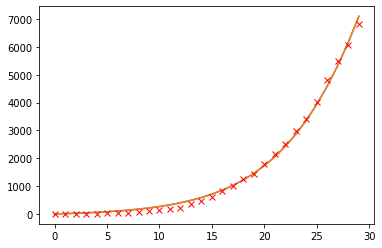

In [73]:
deaths_multiplier = 1
fit_range = (0, 30)
df = pd.read_csv('../data/dpc-covid19-ita-andamento-nazionale.csv').drop('stato',1)
N = populations['Italy']
y_fit = deaths_multiplier*df['deceduti'].iloc[fit_range[0]:fit_range[1]].values # variable to fit
D0 = deaths_multiplier*df['deceduti'].iloc[fit_range[0]]
I0 = df['totale_positivi'].iloc[fit_range[0]]
R0 = df['dimessi_guariti'].iloc[fit_range[0]]
S0 = N - I0 - R0 - D0 
time_range = 300
beta, gamma, theta = calibrate_SIR(
    y = y_fit,
    fit_range = fit_range,
    N = N,
    S0 = S0,
    I0 = I0,
    R0 = R0,
    D0 = D0,
    bounds= [
        (-90000, 90000), #beta
        (-90000, 90000),#gamma
        (-90000, 90000),#theta
       ],
    plot_range = 150,
    plot_output = ['S','I','D']
)